# Stuff

In [1]:
N = 3  # Number of analogues to each query spectrum
TEST_SLICE = -1  # set to -1 for full set

# SSMMCS parameters
SIMILARITY_THESHOLD = 0.2
NORMALIZE_WEIGHTS = "True"
# Morgan fingerprint parameters
MORGAN_RADIUS = 9
NBITS = 2048
USE_FEATURES = False
FPTYPE = "bv"  # "bv" (bitvector) or "count"

# FMCS parameters
TIMEOUT = 60

In [2]:
import sys
import os

# Get path to the parent directory containing the package
MAIN_FOLDER = os.path.abspath(
    os.path.join(os.getcwd(), "../ms_chemical_space_explorer")
)
DATA_FOLDER = "data"
PROCESSED_DATA_FOLDER = "processed"
FILENAME = "1000_test_spectra.mgf"
FILEPATH = os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER, FILENAME)
PICKLE = "pickle"

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [3]:
from rdkit import Chem
from ms_chemical_space_explorer.fragment_extractor import (
    generate_mols_from_spectrum_query,
)
import pickle
from ms_chemical_space_explorer.chemical_space_explorer import start_workflow
from tqdm.notebook import trange, tqdm

# Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [4]:
from typing import Callable
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFMCS
import pandas as pd

class BenchmarkParams:
    """
    Class to hold parameters for MCS benchmarking.
    """

    def __init__(
        self, method_name: str = "mcs algorithm not defined", file_name: str = FILENAME
    ):
        self.method_name = method_name
        self.file_name = file_name

    def __str__(self) -> str:
        return f"file={self.file_name}"

    def __repr__(self) -> str:
        return self.__str__()

class SSMBenchmarkParams(BenchmarkParams):
    """
    Class to hold parameters for SSMMCS benchmarking.
    """

    def __init__(
        self,
        method_name: str = "SSMMCS",
        file_name: str = FILENAME,
        sim_map_threshold: float = SIMILARITY_THESHOLD,
        normalize_weigths: str = NORMALIZE_WEIGHTS,
        fingerprint_function: str = "MORGAN",
        min_num_atoms: int = 1,
    ):
        super().__init__(method_name=method_name, file_name=file_name)
        self.fingerprint_function = fingerprint_function.upper()
        self.similarity_threshold = sim_map_threshold
        self.normalize_weights = normalize_weigths
        # MORGAN fingerprint parameters
        self.morgan_radius = MORGAN_RADIUS
        self.nbits = NBITS
        self.use_features = USE_FEATURES
        self.fp_type = FPTYPE
        self.min_num_atoms = min_num_atoms

    def __str__(self) -> str:
        return f"SSMMCS-Benchmark_threshold={self.similarity_threshold}_normalize={self.normalize_weights}_{self.get_fingerprint_params()}_{super().__str__()}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_fingerprint_params(self) -> str:
        param_string = f"fp={self.fingerprint_function}"

        if self.fingerprint_function == "MORGAN":
            return f"{param_string}_r={self.morgan_radius}_type={self.fp_type}_nBits={self.nbits}_useFeatures={self.use_features}"

        return f"{param_string}"

    def get_fingerprint_function(self, mol, atom_id, **kwargs) -> Callable:
        if self.fingerprint_function == "MORGAN":
            return SimilarityMaps.GetMorganFingerprint(
                mol,
                atom_id,
                radius=self.morgan_radius,
                fpType=self.fp_type,
                nBits=self.nbits,
                useFeatures=self.use_features,
                **kwargs,
            )
        elif self.fingerprint_function == "AP":
            return SimilarityMaps.GetAPFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "TT":
            return SimilarityMaps.GetTTFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "RDK":
            return SimilarityMaps.GetRDKFingerprint(mol, atom_id, **kwargs)
        else:
            raise ValueError(
                f"Unknown fingerprint function: {self.fingerprint_function}"
            )

class ChemSpaceExplorerBenchmarkParams:
    """
    Class to hold parameters for benchmarking on ChemSpaceExplorer results.
    """

    def __init__(
        self,
        analogues: pd.DataFrame,
        n: int = N,
        test_slice: int = TEST_SLICE,
        method_params: BenchmarkParams = SSMBenchmarkParams(),
    ):
        self.analogues = analogues
        self.n = n
        self.test_slice = test_slice
        self.method_params = method_params

    def __str__(self) -> str:
        if self.test_slice >= 0:
            return f"CSE_n={self.n}_slice={self.test_slice}_{self.method_params}"

        return f"CSE_n={self.n}-{self.method_params}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_method_params(self):
        if self.method_params is SSMBenchmarkParams:
            return SSMBenchmarkParams(
                method_name=self.method_params.method_name,
                file_name=self.method_params.file_name,
                sim_map_threshold=self.method_params.sim_map_threshold,
                normalize_weigths=self.method_params.normalize_weights,
                fingerprint_function=self.method_params.fingerprint_function,
            )

    def get_data_slice(self, data):
        if self.test_slice >= 0:
            return data[: self.test_slice]

        return data

# Chemspace Explorer Initialization

In [5]:
from ms_chemical_space_explorer.chemical_space_explorer import spectra_importer

query_spectra = spectra_importer(FILEPATH)

Processing spectra: 100%|██████████| 1000/1000 [00:04<00:00, 232.28it/s]


In [6]:
def analogue_search(explorer, n: int = 2, epsilon: float = 0.2) -> pd.DataFrame:
    file = os.path.join(PICKLE, f"results_n={n}.pkl")
    try:
        with open(file, "rb") as f:
            analogues = pickle.load(f)
            print(f"Loaded analogues from {file}")

    except FileNotFoundError:
        analogues = explorer.analogue_search(query_spectra, n=n, epsilon=epsilon)

        with open(file, "wb") as f:
            pickle.dump(analogues, f)
        print(f"Analogues saved to {file}")

    return analogues

In [7]:
def generate_query_mols():
    file = os.path.join(PICKLE, f"{len(query_spectra)}_query_mols_for_{FILENAME}.pkl")
    query_mols = []
    try:
        with open(file, "rb") as f:
            query_mols = pickle.load(f)
            print(f"Loaded {len(query_mols)} query mols from {file}")

    except FileNotFoundError:
        for query_id, query_spectrum in tqdm(
            enumerate(query_spectra), desc="Generating query mols...", unit="mols"
        ):
            mol = Chem.MolFromSmiles(query_spectrum.metadata["smiles"])
            query_mols.append(mol)

        with open(file, "wb") as f:
            pickle.dump(query_mols, f)
        print(f"{len(query_mols)} query mols saved to {file}.")

    return query_mols

def generate_analogue_mols(dataFrame: pd.DataFrame, n=N):
    file = os.path.join(
        PICKLE,
        f"n={n}_analogue_dataframe_with_{len(query_spectra)*n}_mols_for_{FILENAME}.pkl",
    )
    try:
        with open(file, "rb") as f:
            dataFrame = pickle.load(f)
            print(f"Loaded dataframe with {len(dataFrame)} analogues from {file}")

    except FileNotFoundError:
        for idx, row in tqdm(
            dataFrame.iterrows(),
            desc="Adding mols to analogue dataframe...",
            unit="mols",
        ):
            mol = Chem.MolFromSmiles(row["smiles"])
            dataFrame.loc[idx, "mol"] = mol

        with open(file, "wb") as f:
            pickle.dump(dataFrame, f)
        print(f"Dataframe with {len(dataFrame)} analogue mols saved to {file}.")

    return dataFrame

In [8]:
if TEST_SLICE > 0:
    query_mols = generate_query_mols()[:TEST_SLICE]
else:
    query_mols = generate_query_mols()

Loaded 603 query mols from pickle\603_query_mols_for_1000_test_spectra.mgf.pkl


In [9]:
# sanity check
if TEST_SLICE > 0:
    assert len(query_mols[:TEST_SLICE]) == len(query_spectra[:TEST_SLICE])
else:
    assert len(query_mols) == len(query_spectra)

len(query_spectra) * N

1809

#### helper functions

In [10]:
def chemspace_explorer_benchmark(
    query_mols, params: ChemSpaceExplorerBenchmarkParams, method: Callable
):
    filename = f"{len(query_mols)}_results_for_{params}.csv"
    # Sanitize the whole filename again just to be safe
    filename = sanitize_filename(filename)
    file = os.path.join(DATA_FOLDER, filename)

    if os.path.exists(file):
        df = pd.read_csv(file)
        print(f"Loaded {len(df)} {params.method_params.method_name} results from {file}.")
    else:
        try:
            print(f"Running {params.method_params.method_name}...")
            df = method(query_mols, params.analogues, params.method_params, params.n)

            if len(df) == 0:
                print(f"No results for {params.method_params}.")
                return None

            # Save CSV once after all processing is complete
            os.makedirs(os.path.dirname(file), exist_ok=True)
            df.to_csv(file, index=False)
            print(f"Saved {len(df)} {params.method_params.method_name} results to {file}.")
        except Exception as e:
            print(f"Error during {params.method_params.method_name} processing: {e}")
            return None

    return df

def sanitize_filename(filename):
    """Replace invalid filename characters with underscores."""
    # Characters not allowed in Windows filenames
    invalid_chars = r'<>:"/\|?*(),'
    for char in invalid_chars:
        filename = filename.replace(char, "___")
    return filename

In [11]:
def get_query_analogues(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["mol"].tolist()

In [12]:
from ms_chemical_space_explorer.chemical_space_visualizer import draw_mol, draw_images
import rdkit.Chem.Draw as Draw

def draw_query_and_analogues(query_id: int, query_spectra: list[Chem.Mol], analogue_df: pd.DataFrame) -> None:
    query_analogues = analogue_df[analogue_df["query_spectrum_id"] == query_id]
    query_smiles = query_spectra[query_id].metadata["smiles"]
    query_imgs = []
    draw2d = Draw.MolDraw2DCairo(400, 400)
    query_mol = Chem.MolFromSmiles(query_smiles)
    query_imgs.append(draw_mol(draw2d, query_mol, legend=f"Query {query_id}\n{query_smiles}"))
    
    analogues = generate_mols_from_spectrum_query(spectrum_query_result=query_analogues)
    
    for i, analogue in enumerate(analogues):
        draw2d = Draw.MolDraw2DCairo(400, 400)
        query_imgs.append(draw_mol(draw2d, analogue, legend=f"Analogue {query_id}.{i}\n{query_analogues.iloc[i]['smiles']}"))
    display(draw_images(query_imgs))

# SSMMCS

In [13]:
from rdkit.Chem.Draw import SimilarityMaps

def get_stacked_sim_map_fragments_and_weights(
    mols: list[Chem.Mol],
    fp_function: Callable = SimilarityMaps.GetMorganFingerprint,
    similarity_threshold: float = SIMILARITY_THESHOLD,
    normalize: str = NORMALIZE_WEIGHTS,
    analogue_weights: list[float] | None = None,
) -> tuple[list[Chem.Mol], list[list[float]]]:

    stacked_weights = []
    all_analogue_fragments = []

    for i, ref_mol in enumerate(mols):
        ref_mol_smiles = Chem.MolToSmiles(ref_mol)
        ref_mol_stacked_weights = [0] * ref_mol.GetNumAtoms()
        for vertical_index, probe_mol in enumerate(mols):
            probe_mol_smiles = Chem.MolToSmiles(probe_mol)
            # Skip if comparing molecule to itself
            if probe_mol_smiles == ref_mol_smiles:
                continue

            # extract similarity weights for the reference molecule
            sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(
                probe_mol, ref_mol, fp_function
            )
            if normalize == "True":
                sim_weights, _ = SimilarityMaps.GetStandardizedWeights(sim_weights)
                print("!!!")

            assert (
                len(sim_weights) == ref_mol.GetNumAtoms()
            ), "Length of sim_weights does not match number of atoms in reference molecule."
            
            # stack the weights
            ref_mol_stacked_weights = [
                ref_mol_stacked_weights[i] + sim_weights[i]
                for i in range(ref_mol.GetNumAtoms())
            ]

        if normalize == "True" or normalize == "stacked_and_query_only":
            ref_mol_stacked_weights, _ = SimilarityMaps.GetStandardizedWeights(
                ref_mol_stacked_weights
            )
        elif len(mols) > 1:
            ref_mol_stacked_weights = [weight / (len(mols) - 1) for weight in ref_mol_stacked_weights]
        
        if analogue_weights is not None:
            ref_mol_stacked_weights = [weight * analogue_weights[i] for weight in ref_mol_stacked_weights]

        stacked_weights.append(ref_mol_stacked_weights)

        # Extract fragments from the reference molecule using the similarity weights
        analogue_fragments = extract_sim_map_fragments_from_mol(
            ref_mol, ref_mol_stacked_weights, similarity_threshold
        )
        all_analogue_fragments.extend(analogue_fragments)

    return all_analogue_fragments, stacked_weights

def find_SSMMCS_and_SSMMSS(
    mols: list[Chem.Mol], substruct_candidates: list[Chem.Mol], min_num_atoms: int = 1
) -> tuple[Chem.Mol | None, Chem.Mol | None]:

    common_substructs = []
    unique_smiles = set()
    mcs_id = -1
    mcs_size = 0
    mss = None
    mss_size = 0

    for substruct in substruct_candidates:
        num_Atoms = substruct.GetNumAtoms()

        # skip substructs below atom threshold
        if num_Atoms < min_num_atoms:
            continue

        # skip duplicates
        smiles = Chem.MolToSmiles(substruct)
        if smiles in unique_smiles:
            continue
        unique_smiles.add(smiles)

        # find the maximum stacked substructure (MSS)
        if num_Atoms > mss_size:
            mss = substruct
            mss_size = num_Atoms

        # find the maximum common substructure (MCS)
        is_common = True
        for analogue in mols:
            if len(analogue.GetSubstructMatch(substruct)) <= 0:
                is_common = False
                break

        if not is_common:
            continue
        common_substructs.append(substruct)

        if num_Atoms > mcs_size:
            mcs_id = len(common_substructs) - 1
            mcs_size = num_Atoms

        # if MSS and MCS are the same size, update MSS to MCS
        if num_Atoms == mss_size:
            mss = common_substructs[mcs_id]

    if mcs_id < 0:
        mcs = None
    else:
        mcs = common_substructs[mcs_id]

    return mcs, mss

def extract_sim_map_fragments_from_mol(
    mol: Chem.Mol, similarity_weights: list[float], similarity_threshold: float
) -> list[Chem.Mol]:

    visited = set()
    fragment_mols = []

    # Iterate through all atoms to find connected_atoms
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        if (
            atom_idx not in visited
            and similarity_weights[atom_idx] >= similarity_threshold
        ):
            connected_atoms = find_connected_atoms_recursive(
                atom_idx, visited, mol, similarity_weights, similarity_threshold
            )
            if connected_atoms:
                # Create a new molecule for this connected_atoms
                fragment = Chem.RWMol(mol)

                # Create a map of atoms to remove (those not in connected_atoms)
                atoms_to_remove = set(range(mol.GetNumAtoms())) - connected_atoms

                # Remove atoms not in connected_atoms (remove in reverse order to preserve indices)
                for remove_idx in sorted(atoms_to_remove, reverse=True):
                    fragment.RemoveAtom(remove_idx)

                # Convert to regular molecule and add to list
                fragment_mols.append(fragment.GetMol())

    return fragment_mols

def find_connected_atoms_recursive(
    atom_idx: int,
    visited: set[int],
    mol: Chem.Mol,
    similarity_weights: list[float],
    similarity_threshold: float,
) -> set[int]:
    if atom_idx in visited or similarity_weights[atom_idx] < similarity_threshold:
        return set()

    atoms = {atom_idx}
    visited.add(atom_idx)

    # Get current atom object
    atom = mol.GetAtomWithIdx(atom_idx)

    # Iterate through bonds to neighboring atoms
    for bond in atom.GetBonds():
        # Get the neighboring atom's index
        neighbor_idx = (
            bond.GetBeginAtomIdx()
            if bond.GetEndAtomIdx() == atom_idx
            else bond.GetEndAtomIdx()
        )

        if similarity_weights[neighbor_idx] >= similarity_threshold:
            atoms.update(
                find_connected_atoms_recursive(
                    neighbor_idx, visited, mol, similarity_weights, similarity_threshold
                )
            )

    return atoms

def score_stacked_weights_against_query(query: Chem.Mol, analogues: list[Chem.Mol], stacked_weights: list[list[float]], fp_fuction: Callable, normalize_query_weights: bool
                                        )-> tuple[float, list[float]]: 
    analogue_weight_differences = []
    for i, analogue in enumerate(analogues):
        assert (len(stacked_weights[i]) == analogue.GetNumAtoms()), f"Length of stacked_weights {i} does not match number of atoms in analogue {i}."
        
        query_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(query, analogue, fp_fuction)
        if(normalize_query_weights == "True" or normalize_query_weights == "stacked_and_query_only"):
            query_weights, _ = SimilarityMaps.GetStandardizedWeights(query_weights)

        atom_weight_differences = [abs(stacked_weights[i][j] - query_weights[j]) for j in range(len(stacked_weights[i]))] # calculate a list of weight differences for each atom
        analogue_weight_differences.append(sum(atom_weight_differences) / len(atom_weight_differences)) # average of all atom weight differences
    
    query_weight_difference = sum(analogue_weight_differences) / len(analogue_weight_differences)
    
    return query_weight_difference, analogue_weight_differences

In [14]:
import time
from rdkit.Chem import Descriptors

def benchmark_ssmmcs(query_mols, analogues: pd.DataFrame, ssmmcs_params: SSMBenchmarkParams, n: int = N) -> pd.DataFrame:
    ssmmcs_df = pd.DataFrame()

    for query_id, query_mol in tqdm(
        enumerate(query_mols), total=len(query_mols), desc=f"SSMMCS with n={n}"
    ):
        try:
            query_analogues = get_query_analogues(query_id, analogues)
            if len(query_analogues) < 2:
                print(
                    f"Skipping query {query_id} due to insufficient number of analogues!"
                )
                continue
            
            # calculate ssmmcs and ssmss
            start_time = time.time()
            all_analogue_fragments, stacked_weigths = get_stacked_sim_map_fragments_and_weights(mols=query_analogues,
                                                                                                fp_function=ssmmcs_params.get_fingerprint_function,
                                                                                                similarity_threshold=ssmmcs_params.similarity_threshold,
                                                                                                normalize=ssmmcs_params.normalize_weights,
                                                                                                )
            elapsed_time = time.time() - start_time
            
            # check the quality of the stacked similarity weights against the actual query similarity weights
            query_weight_diff, analogue_weight_diffs = score_stacked_weights_against_query(
                query_mol, query_analogues, stacked_weigths, ssmmcs_params.get_fingerprint_function, ssmmcs_params.normalize_weights)
            
            # gather analogue data
            isf_scores = analogues[analogues["query_spectrum_id"] == query_id].isf
            isf_mean = isf_scores.mean()
            distances = analogues[analogues["query_spectrum_id"] == query_id].predicted_distance
            distances_mean = distances.mean()

            # Save data as a row
            new_row = {
                "query_id": query_id,
                "query_weight_diff": query_weight_diff, # average of all analogue weight differences
                "analogue_weight_diffs": analogue_weight_diffs, # list of average weight differences for each analogue
                "stacked_weights": stacked_weigths, # list of stacked weights for each analogue
                "isf_scores": isf_scores.tolist(),
                "isf_mean": isf_mean,
                "distances": distances.tolist(),
                "distances_mean": distances_mean,
                "query_size": query_mol.GetNumAtoms(),
                "query_mass": Descriptors.MolWt(query_mol),
                "analogue_sizes": [mol.GetNumAtoms() for mol in query_analogues],
                "mean_analogue_size": sum([mol.GetNumAtoms() for mol in query_analogues]) / len(query_analogues),
                "analogue_masses": [Descriptors.MolWt(mol) for mol in query_analogues],
                "mean_analogue_mass": sum([Descriptors.MolWt(mol) for mol in query_analogues]) / len(query_analogues),
                "time": elapsed_time,
            }
            ssmmcs_df = pd.concat(
                [ssmmcs_df, pd.DataFrame([new_row])], ignore_index=True
            )
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue

    return ssmmcs_df

In [15]:
explorer = start_workflow(os.path.abspath(os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER)))

Initialize ChemExplorer


d:\Programmierung\anaconda3\envs\chemspace\Lib\site-packages\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(

In [33]:
ssmmcs_params = SSMBenchmarkParams(
    method_name="SSMMCS",
    file_name=FILENAME,
    sim_map_threshold=SIMILARITY_THESHOLD,
    normalize_weigths="True",
    fingerprint_function="morgan",
)

In [ ]:
# create a dict with int keys and dataframes as values
benchmark_results = {}

for n in tqdm([*range(2, 11), 15, 20, 30], desc="Benchmarking"):
    n_analogues = analogue_search(explorer=explorer, n=n)
    n_analogues = generate_analogue_mols(n_analogues, n=n)

    cse = ChemSpaceExplorerBenchmarkParams(n=n, analogues=n_analogues, method_params=ssmmcs_params)

    benchmark_results[n] = chemspace_explorer_benchmark(query_mols, params=cse, method=benchmark_ssmmcs)

Benchmarking:   0%|          | 0/10 [00:00<?, ?it/s]

Loaded analogues from pickle\results_n=2.pkl
Loaded dataframe with 1205 analogues from pickle\n=2_analogue_dataframe_with_1206_mols_for_1000_test_spectra.mgf.pkl
Loaded 602 SSMMCS results from data\603_results_for_CSE_n=2-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=3.pkl
Loaded dataframe with 1806 analogues from pickle\n=3_analogue_dataframe_with_1809_mols_for_1000_test_spectra.mgf.pkl
Loaded 602 SSMMCS results from data\603_results_for_CSE_n=3-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=4.pkl
Loaded dataframe with 2404 analogues from pickle\n=4_analogue_dataframe_with_2412_mols_for_1000_test_spectra.mgf.pkl
Loaded 602 SSMMCS results from data\603_results_for_CSE_n=4-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=20

In [35]:
benchmark_results[6].isf_mean.max()

0.9648225872610716

In [36]:
benchmark_results[6][benchmark_results[6]["query_mass"].between(0, 5)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   query_id               0 non-null      int64  
 1   time                   0 non-null      float64
 2   query_size             0 non-null      int64  
 3   query_mass             0 non-null      float64
 4   analogue_smiles        0 non-null      object 
 5   analogue_sizes         0 non-null      object 
 6   mean_analogue_size     0 non-null      float64
 7   analogue_masses        0 non-null      object 
 8   mean_analogue_mass     0 non-null      float64
 9   isf_scores             0 non-null      object 
 10  isf_mean               0 non-null      float64
 11  distances              0 non-null      object 
 12  distances_mean         0 non-null      float64
 13  query_weight_diff      0 non-null      float64
 14  analogue_weight_diffs  0 non-null      object 
 15  stacked_weights        

# Benchmark results

In [37]:
def animate_benchmark(benchmark_results: dict, x_column: str, y_column: str, title: str = "Benchmark", keys=None, mask_min: float = 0, mask_max: float = 2000, mask_column: str = "",
                     interval: int = 500, figsize=(8, 6), color="blue", 
                     alpha=0.5, save_gif=False, gif_filename=None, fps=2,
                     class_column: str = None, class_ranges: list = None, class_cmap: str = "viridis"):
    """
    Create an animated scatter plot from benchmark results with fixed axis limits.
    
    Parameters:
    -----------
    benchmark_results : dict
        Dictionary of dataframes with non-sequential keys
    x_column : str
        Column name to use for x-axis
    y_column : str
        Column name to use for y-axis
    interval : int, optional
        Animation interval in milliseconds, default is 500
    figsize : tuple, optional
        Figure size (width, height) in inches, default is (8, 6)
    color : str, optional
        Color for scatter points when not using classification, default is "blue"
    alpha : float, optional
        Transparency for scatter points, default is 0.5
    save_gif : bool, optional
        Whether to save animation as a GIF, default is False
    gif_filename : str, optional
        Filename for the GIF, default is "benchmark_animation.gif"
    fps : int, optional
        Frames per second for GIF, default is 2
    class_column : str, optional
        Column to use for classification-based coloring
    class_ranges : list, optional
        List of tuples defining class boundaries e.g. [(20,29), (30,39)]
        
    Returns:
    --------
    IPython.display.HTML
        HTML object containing the animation
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    import matplotlib
    import pandas as pd
    import numpy as np
    import matplotlib.colors as mcolors
    
    # Use a non-interactive backend to prevent extra figures
    matplotlib.use('Agg')
    
    # Get the keys from the benchmark_results dictionary
    if keys is None:
        keys = list(benchmark_results.keys())
    
    # Determine global min and max values for both axes
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')
    
    for key in keys:
        if mask_column != "":
            df = benchmark_results[key][benchmark_results[key][mask_column].between(mask_min, mask_max)]
        else:
            df = benchmark_results[key]
        x_data = df[x_column]
        y_data = df[y_column]
        
        # Update min and max values, handling NaN values
        x_min = min(x_min, x_data.min() if not pd.isna(x_data.min()) else x_min)
        x_max = max(x_max, x_data.max() if not pd.isna(x_data.max()) else x_max)
        y_min = min(y_min, y_data.min() if not pd.isna(y_data.min()) else y_min)
        y_max = max(y_max, y_data.max() if not pd.isna(y_data.max()) else y_max)
    
    # Add a small padding (5%) to the axes limits for better visualization
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    x_min = x_min - 0.05 * x_range
    x_max = x_max + 0.05 * x_range
    y_min = y_min - 0.05 * y_range
    y_max = y_max + 0.05 * y_range
    
    # Setup for classification-based coloring
    use_classes = (class_column is not None and class_ranges is not None)
    
    # Define color map for classes if using classification
    if use_classes:
        cmap = mpl.colormaps[class_cmap].resampled(len(class_ranges) + 2)
        class_colors = [cmap(i) for i in range(len(class_ranges) + 2)]
        
        # Define class boundaries and labels
        min_val = float('-inf')
        max_val = float('inf')
        class_boundaries = [min_val] + [r[0] for r in class_ranges] + [r[1] for r in class_ranges[-1:]] + [max_val]
        class_labels = [f'< {class_ranges[0][0]}']
        
        for i, (low, high) in enumerate(class_ranges):
            class_labels.append(f'{low}-{high}')
        
        class_labels.append(f'> {class_ranges[-1][1]}')
    
    # Create a figure for the animation
    fig, ax = plt.subplots(figsize=figsize)
    plt.close()  # Close the initial figure to prevent it from displaying
    
    # Function to update the animation frame
    def update(frame_idx):
        ax.clear()
        
        # Get the actual key for this frame
        key = keys[frame_idx]
        
        # Get the data from benchmark_results
        if mask_column != "":
            df = benchmark_results[key][benchmark_results[key][mask_column].between(mask_min, mask_max)]
        else:
            df = benchmark_results[key]
        
        if use_classes:
            # Create a categorical column for coloring
            class_indices = np.zeros(len(df), dtype=int)
            
            # Classify data points
            for i, (low, high) in enumerate(class_ranges, start=1):
                # Class: points within the current range
                mask = (df[class_column] >= low) & (df[class_column] <= high)
                class_indices[mask] = i
            
            # Class: points above the highest range
            mask = df[class_column] > class_ranges[-1][1]
            class_indices[mask] = len(class_ranges) + 1
            
            # Create scatter plot for each class
            scatter_plots = []
            for i in range(len(class_ranges) + 2):
                mask = class_indices == i
                if sum(mask) > 0:
                    scatter = ax.scatter(
                        df.loc[mask, x_column], 
                        df.loc[mask, y_column], 
                        c=[class_colors[i]], 
                        alpha=alpha, 
                        label=class_labels[i]
                    )
                    scatter_plots.append(scatter)
            
            # Add legend with the class_column as the title
            ax.legend(title=class_column)
        else:
            # Original behavior: single color scatter plot
            scatter = ax.scatter(df[x_column], df[y_column], alpha=alpha, color=color)
            scatter_plots = [scatter]
        
        # Set fixed axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        
        ax.set_title(f'{title} (n={key})')
        ax.set_xlabel(x_column)
        ax.set_ylabel(y_column)
        
        return scatter_plots
    
    # Create the animation
    anim = FuncAnimation(fig, update, frames=len(keys), interval=interval, blit=False)
    
    # Save as GIF if requested
    if save_gif:
        filename = gif_filename if gif_filename else f"{title} - {y_column} over {x_column}.gif"
        anim.save(filename, writer='pillow', fps=fps)
    
    # Return the animation as HTML
    return HTML(anim.to_jshtml())

In [38]:
from IPython.display import HTML

# List of your GIF files
# gif_files = ["Normalize everything - mean_distance over mean_isf.gif",
#              "Normalize nothing - distances_mean over isf_mean.gif"]
# gif_files = ["Normalize everything - query_weight_diff over mean_distance.gif",
#              "Normalize nothing - query_weight_diff over distances_mean.gif",]
gif_files = ["Normalize everything - query_weight_diff over mean_isf.gif",
             "Normalize nothing - query_weight_diff over isf_mean.gif",]

# Create HTML for side-by-side display
html_content = '<div style="display: flex; justify-content: space-between;">'
for gif in gif_files:
    html_content += f'<div style="margin: 0 10px;"><img src="{gif}"></div>'
html_content += '</div>'

# Display in the notebook
HTML(html_content)

In [ ]:
animation = animate_benchmark(
    benchmark_results=benchmark_results,
    x_column="mean_analogue_mass",
    y_column="query_weight_diff",
    title="weight diff score over analogue mass",
    keys=[*range(2, 11), 15, 20, 30],
    class_column="mean_analogue_size",
    class_ranges=[(20, 30), (30, 40)],
    class_cmap="viridis",
    #class_ranges=[(250, 350), (351, 500)],
    #save_gif=True,
    # mask_column="mean_analogue_size",
    # mask_min=20,
    # mask_max=40,
)
animation

<Axes: >

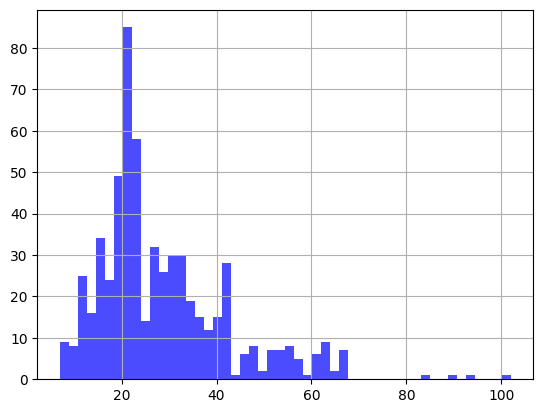

In [74]:
benchmark_results[10]["query_size"].hist(bins=50, alpha=0.7, color='blue', label="Query size distribution")

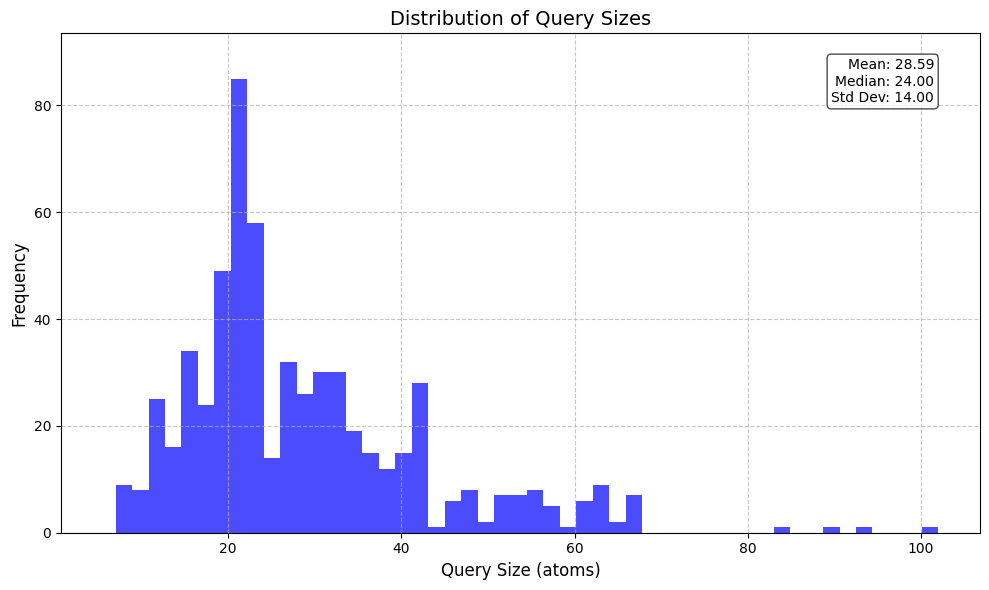

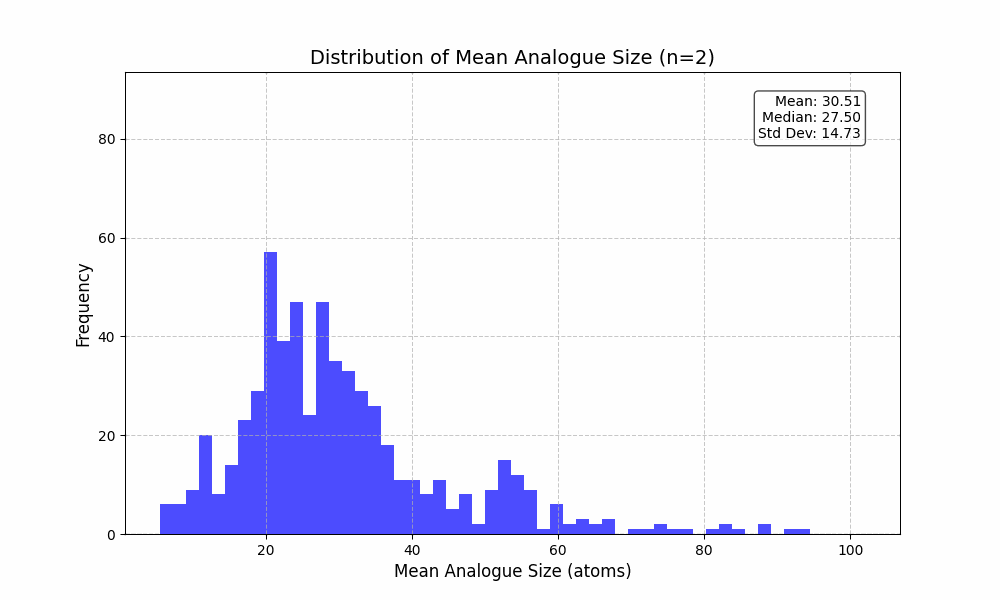

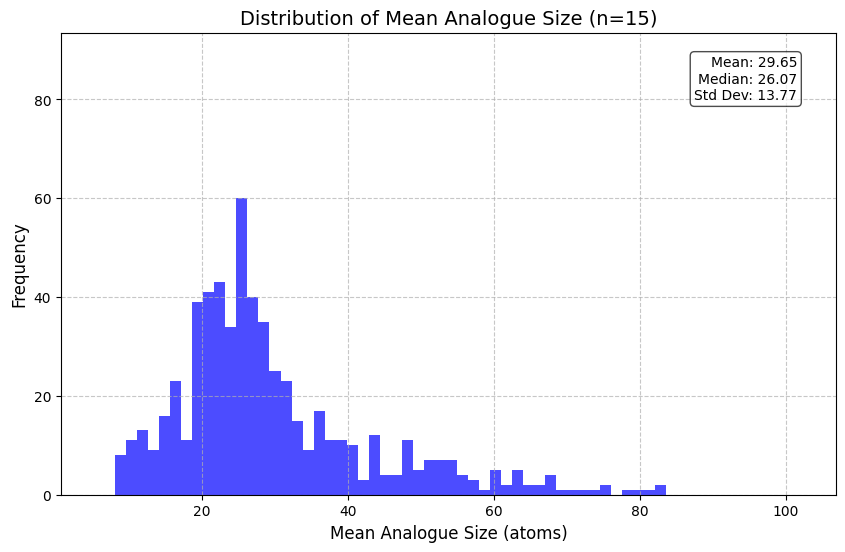

In [81]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

# First, determine global min and max values for both query_size and mean_analogue_size
# and find the global maximum count for consistent y-axis
x_min = float('inf')
x_max = float('-inf')
global_max_count = 0

n_values = list(benchmark_results.keys())

# Check query size ranges
for n in n_values:
    query_data = benchmark_results[n]["query_size"]
    x_min = min(x_min, query_data.min())
    x_max = max(x_max, query_data.max())
    
    # Calculate histogram counts to find max y-value
    counts, _ = np.histogram(query_data, bins=50)
    global_max_count = max(global_max_count, max(counts))

# Check mean analogue size ranges
for n in n_values:
    analogue_data = benchmark_results[n]["mean_analogue_size"]
    x_min = min(x_min, analogue_data.min())
    x_max = max(x_max, analogue_data.max())
    
    # Calculate histogram counts to find max y-value
    counts, _ = np.histogram(analogue_data, bins=50)
    global_max_count = max(global_max_count, max(counts))

# Add padding to the limits
padding = (x_max - x_min) * 0.05
x_min = x_min - padding
x_max = x_max + padding

# Add padding to y-axis max
y_max = global_max_count * 1.1

# STATIC PLOT: Query Size Histogram
def plot_query_size_histogram(n=10):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data = benchmark_results[n]["query_size"]
    
    # Create histogram
    counts, bins, patches = ax.hist(data, bins=50, alpha=0.7, color='blue')
    
    # Set consistent axis limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)
    
    # Add labels and title
    ax.set_xlabel('Query Size (atoms)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Distribution of Query Sizes', fontsize=14)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add text with statistics
    mean = data.mean()
    median = data.median()
    std = data.std()
    stats_text = f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std:.2f}"
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.savefig('query_size_distribution_shared_scale.png', dpi=300)
    plt.show()

# ANIMATION: Mean Analogue Size Histogram
def create_mean_analogue_size_animation():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Function to update the plot for each frame
    def update(frame):
        ax.clear()
        n = n_values[frame]
        data = benchmark_results[n]["mean_analogue_size"]
        
        # Create histogram
        counts, bins, patches = ax.hist(data, bins=50, alpha=0.7, color='blue')
        
        # Set consistent limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(0, y_max)
        
        # Add labels and title
        ax.set_xlabel('Mean Analogue Size (atoms)', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Distribution of Mean Analogue Size (n={n})', fontsize=14)
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add text with statistics
        mean = data.mean()
        median = data.median()
        std = data.std()
        stats_text = f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd Dev: {std:.2f}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        return [patches]
    
    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(n_values), blit=False, interval=800)
    
    # Save as gif
    ani.save('mean_analogue_size_distribution_shared_scale.gif', writer=PillowWriter(fps=1))
    
    # Display the gif in the notebook
    from IPython.display import Image
    return Image(filename='mean_analogue_size_distribution_shared_scale.gif')

# Create both visualizations with shared scales
plot_query_size_histogram(10)
create_mean_analogue_size_animation()

In [40]:
from io import StringIO

def string_to_list(str_list):
    return pd.read_json(StringIO(str_list), typ="series").to_list()

str_list = '[0.4540343436528938, 0.43230062604081615, 0.17315783087512396, 0.1417363144825612, 0.1752222777902661]'

# Method 1: Using pd.read_json()
numbers_list = string_to_list(str_list)
print(numbers_list)
print(type(numbers_list))

[0.454034343652893, 0.43230062604081604, 0.17315783087512301, 0.14173631448256102, 0.175222277790266]
<class 'list'>


In [41]:
n_analogues = analogue_search(explorer=explorer, n=3)


Loaded analogues from pickle\results_n=3.pkl


In [42]:
query_id = 15
n_analogues[n_analogues["query_spectrum_id"] == query_id]

,smiles,predicted_distance,mean_distance,std_distance,isf,candidate_mean_similarity,candidate_std_similarity,precursor_mz_diff,visual_x,visual_y,inchikey,query_spectrum_id,ionmode
999,c1ccc(c(c1)C(=O)O)C(=O)O,0.163526,0.15025,0.013193,0.324598,0.221898,0.285497,43.9890,15.352127,1.006775,XNGIFLGASWRNHJ,15,negative
1000,c1cc(ccc1C(=O)O)C(=O)O,0.135761,0.15025,0.013193,0.301757,0.221898,0.285497,43.9890,14.353535,2.671011,KKEYFWRCBNTPAC,15,negative
1001,CCOC(=O)C1=CC=CC=C1C(=O)O,0.126034,0.15025,0.013193,0.299569,0.221898,0.285497,72.0206,8.902815,-5.091995,YWWHKOHZGJFMIE,15,negative


In [43]:
n = 15
qid = 305
n_analogues = analogue_search(explorer=explorer, n=n)
analogue_weights = benchmark_results[n]['analogue_weight_diffs'].apply(string_to_list)

isf_scores = n_analogues.groupby("query_spectrum_id")["isf"].apply(list)

# Multiply each analogue weight with its corresponding ISF weight
isf_weighted_diffs = []
for aw, dw in zip(analogue_weights, isf_scores):
	# Multiply corresponding elements from both lists
	weighted = [a * i for a, i in zip(aw, dw)]
	isf_weighted_diffs.append(weighted)

print("length of lists")
print(len(analogue_weights))
print(len(isf_scores))
print(len(isf_weighted_diffs))

print("length weigths for specific id")
print(len(isf_scores[qid]))
print(len(isf_weighted_diffs[qid]))
print(len(isf_weighted_diffs[qid]))

print("specific lists")
print(isf_scores[qid])
print(n_analogues[n_analogues["query_spectrum_id"] == qid]["isf"].tolist())
print(analogue_weights[qid])
print(isf_weighted_diffs[qid])

Loaded analogues from pickle\results_n=15.pkl
length of lists
603
603
603
length weigths for specific id
15
15
15
specific lists
[0.38145325283539777, 0.38145325283539777, 0.38145325283539777, 0.34630139946998084, 0.34261897083335874, 0.3300295789209678, 0.3253470615900949, 0.3112136236943706, 0.30128525388875, 0.2879091325853185, 0.28671975750024314, 0.20548180494634297, 0.19895201120159148, 0.19895201120159148, 0.16813782649800932]
[0.38145325283539777, 0.38145325283539777, 0.38145325283539777, 0.34630139946998084, 0.34261897083335874, 0.3300295789209678, 0.3253470615900949, 0.3112136236943706, 0.30128525388875, 0.2879091325853185, 0.28671975750024314, 0.20548180494634297, 0.19895201120159148, 0.19895201120159148, 0.16813782649800932]
[0.23170784244431702, 0.22644606409516901, 0.26963110503719, 0.32732013229536605, 0.489061533986949, 0.27207524682133905, 0.379437471475612, 0.23996513876849102, 0.27645314706831203, 0.20605395167873303, 0.20712212973972602, 0.495785154037131, 0.1204956

In [45]:
weight_diff_benchmark_df = pd.DataFrame()

for n, df in benchmark_results.items():
    # if(n < 4):
    #     continue
    
    n_analogues = analogue_search(explorer=explorer, n=n)
    
    analogue_weights = df['analogue_weight_diffs'].apply(string_to_list)
    isf_scores = n_analogues.groupby("query_spectrum_id")["isf"].apply(list)
    distance_scores = n_analogues.groupby("query_spectrum_id")["predicted_distance"].apply(list)
    
    # sim weights ISF weighted
    isf_weighted_diffs = []
    for aw, iw in zip(analogue_weights, isf_scores):
        weighted_isf_scores = [a * i for a, i in zip(aw, iw)]
        mean_isf = sum(weighted_isf_scores) / len(weighted_isf_scores)
        isf_weighted_diffs.append(mean_isf)
    
    # sim weights distance weighted
    distance_weighted_diffs = []
    for aw, dw in zip(analogue_weights, distance_scores):
        weighted_distance_scores = [a * d for a, d in zip(aw, dw)]
        mean_distance = sum(weighted_distance_scores) / len(weighted_distance_scores)
        distance_weighted_diffs.append(mean_distance)
    
    benchmark_results[n]["isf_scores"] = isf_scores
    benchmark_results[n]["isf_scores_mean"] = isf_scores.apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
    benchmark_results[n]["distance_scores"] = distance_scores
    benchmark_results[n]["distance_scores_mean"] = n_analogues.groupby("query_spectrum_id")["predicted_distance"].mean()
    benchmark_results[n]["similarity_mean"] = n_analogues.groupby("query_spectrum_id")["candidate_mean_similarity"].mean()
    benchmark_results[n]["query_weight_diff_isf"] = isf_weighted_diffs
    benchmark_results[n]["query_weight_diff_distance"] = distance_weighted_diffs
    
    row_dict = {
            "n": n,
            "time_mean": df["time"].mean(),
            
            "mean": df["query_weight_diff"].mean(),
            "max": df["query_weight_diff"].max(),
            "min": df["query_weight_diff"].min(),
            "std": df["query_weight_diff"].std(),
            "cv": df["query_weight_diff"].std() / df["query_weight_diff"].mean(),
            "median": df["query_weight_diff"].median(),
            
            "mean_isf": df["query_weight_diff_isf"].mean(),
            "max_isf": df["query_weight_diff_isf"].max(),
            "min_isf": df["query_weight_diff_isf"].min(),
            "std_isf": df["query_weight_diff_isf"].std(),
            "cv_isf": df["query_weight_diff_isf"].std() / df["query_weight_diff_isf"].mean(),
            "median_isf": df["query_weight_diff_isf"].median(),
            
            "mean_distance": df["query_weight_diff_distance"].mean(),
            "max_distance": df["query_weight_diff_distance"].max(),
            "min_distance": df["query_weight_diff_distance"].min(),
            "std_distance": df["query_weight_diff_distance"].std(),
            "cv_distance": df["query_weight_diff_distance"].std() / df["query_weight_diff_distance"].mean(),
            "median_distance": df["query_weight_diff_distance"].median(),
            
            "mean_isf_score": df["isf_scores_mean"].mean(),
            "max_isf_score": df["isf_scores_mean"].max(),
            "min_isf_score": df["isf_scores_mean"].min(),
            "std_isf_score": df["isf_scores_mean"].std(),
            "cv_isf_score": df["isf_scores_mean"].std() / df["isf_scores_mean"].mean(),
            "median_isf_score": df["isf_scores_mean"].median(),
            
            "mean_distance_score": df["distance_scores_mean"].mean(),
            "max_distance_score": df["distance_scores_mean"].max(),
            "min_distance_score": df["distance_scores_mean"].min(),
            "std_distance_score": df["distance_scores_mean"].std(),
            "cv_distance_score": df["distance_scores_mean"].std() / df["distance_scores_mean"].mean(),
            "median_distance_score": df["distance_scores_mean"].median(),
            
            "mean_similarity": df["similarity_mean"].mean(),
            "max_similarity": df["similarity_mean"].max(),
            "min_similarity": df["similarity_mean"].min(),
            "std_similarity": df["similarity_mean"].std(),
            "cv_similarity": df["similarity_mean"].std() / df["similarity_mean"].mean(),
            "median_similarity": df["similarity_mean"].median(),
        }
        
    weight_diff_benchmark_df = pd.concat([weight_diff_benchmark_df, pd.DataFrame([row_dict])], ignore_index=True)

Loaded analogues from pickle\results_n=2.pkl
Loaded analogues from pickle\results_n=3.pkl
Loaded analogues from pickle\results_n=4.pkl
Loaded analogues from pickle\results_n=5.pkl
Loaded analogues from pickle\results_n=6.pkl
Loaded analogues from pickle\results_n=7.pkl
Loaded analogues from pickle\results_n=8.pkl
Loaded analogues from pickle\results_n=9.pkl
Loaded analogues from pickle\results_n=10.pkl
Loaded analogues from pickle\results_n=15.pkl


In [46]:
weight_diff_benchmark_df

,n,time_mean,mean,max,min,std,cv,median,mean_isf,max_isf,...,min_distance_score,std_distance_score,cv_distance_score,median_distance_score,mean_similarity,max_similarity,min_similarity,std_similarity,cv_similarity,median_similarity
0,2,0.020683,0.463298,1.022661,0.002808,0.188211,0.406242,0.464840,0.188735,0.666936,...,0.004048,0.069950,0.413291,0.172137,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
1,3,0.062616,0.424016,1.014413,0.022741,0.164669,0.388356,0.420323,0.170672,0.667051,...,0.005092,0.069563,0.407831,0.171753,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
2,4,0.118560,0.401635,0.922193,0.024515,0.152877,0.380637,0.394336,0.158477,0.610384,...,0.004394,0.069735,0.405287,0.176278,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
3,5,0.192341,0.384882,0.901204,0.020552,0.141460,0.367541,0.374840,0.148204,0.542365,...,0.004810,0.069569,0.401850,0.176275,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
4,6,0.285338,0.375625,0.903133,0.017372,0.133107,0.354360,0.376875,0.140975,0.523688,...,0.004420,0.069791,0.401426,0.177676,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
5,7,0.395134,0.368256,0.895468,0.016002,0.125860,0.341772,0.360908,0.134515,0.524180,...,0.003927,0.069431,0.398245,0.177651,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
6,8,0.522120,0.361958,0.776417,0.035764,0.118168,0.326469,0.359743,0.128344,0.470821,...,0.004079,0.069207,0.396609,0.177913,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
7,9,0.667258,0.358299,0.695451,0.037642,0.109498,0.305604,0.360253,0.121662,0.410039,...,0.003645,0.069076,0.395431,0.177277,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
8,10,0.827571,0.355632,0.699275,0.037789,0.107141,0.301270,0.351268,0.113972,0.390208,...,0.003641,0.069106,0.394416,0.176841,0.329672,0.951327,0.01000,0.165189,0.501071,0.291761
9,15,1.982766,0.350449,0.745843,0.044627,0.101344,0.289182,0.349540,0.102525,0.398099,...,0.006111,0.070014,0.378683,0.187065,0.300584,0.946104,0.02595,0.157043,0.522460,0.256806


## Plots

In [47]:
%matplotlib inline

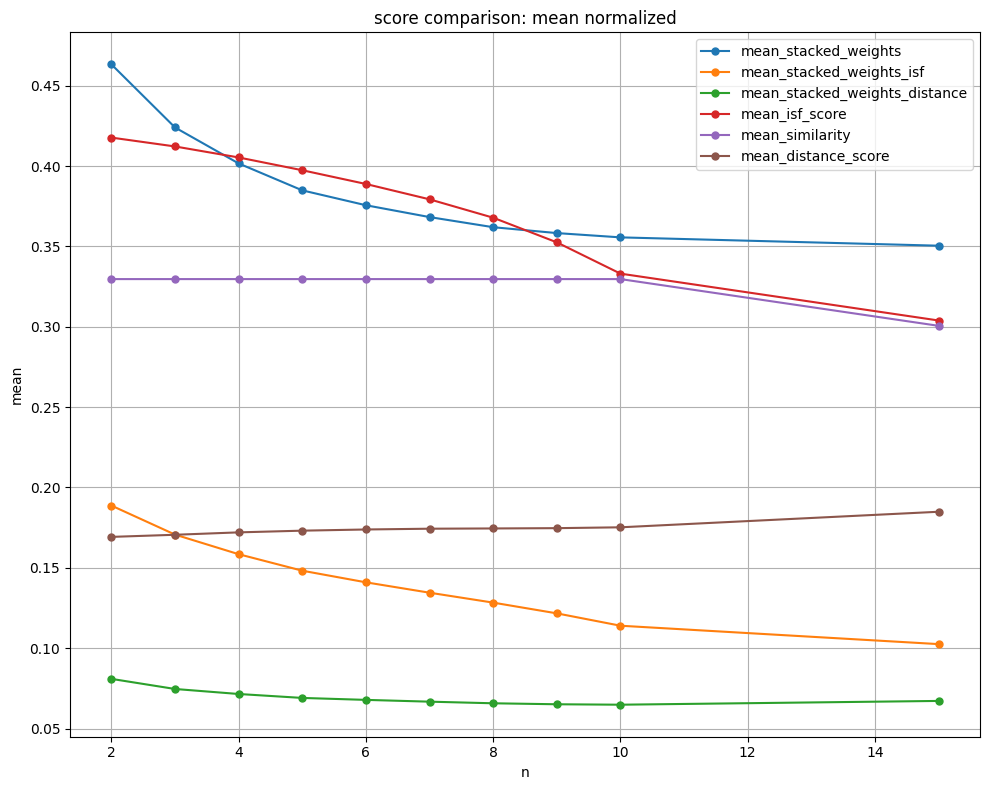

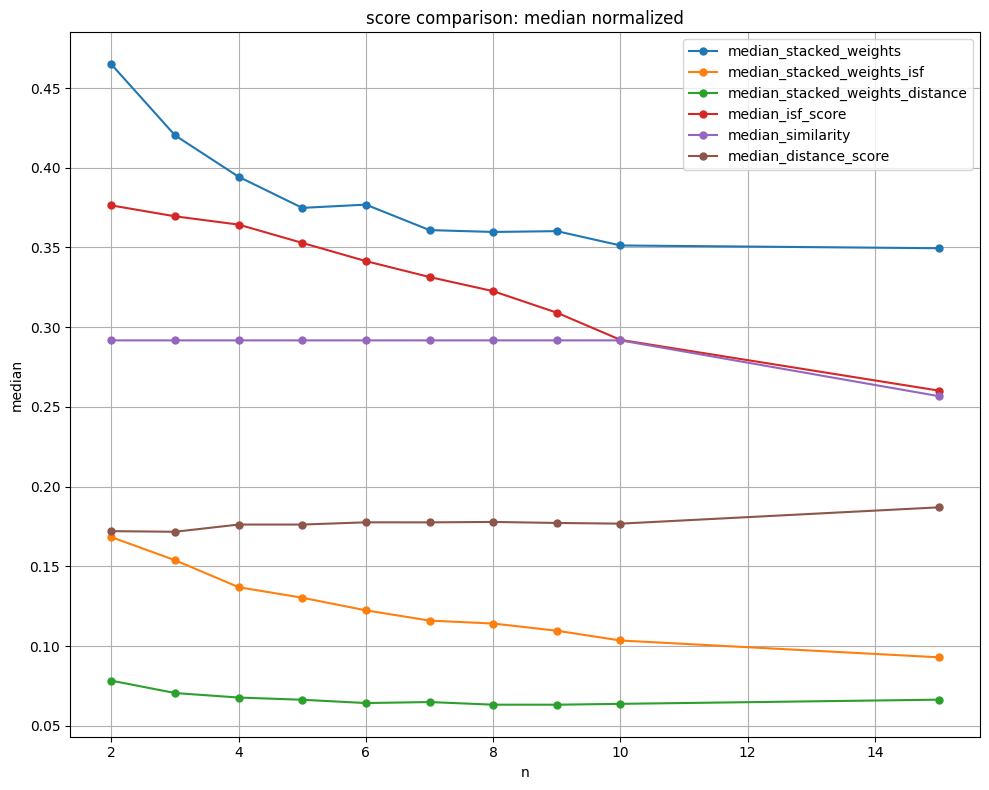

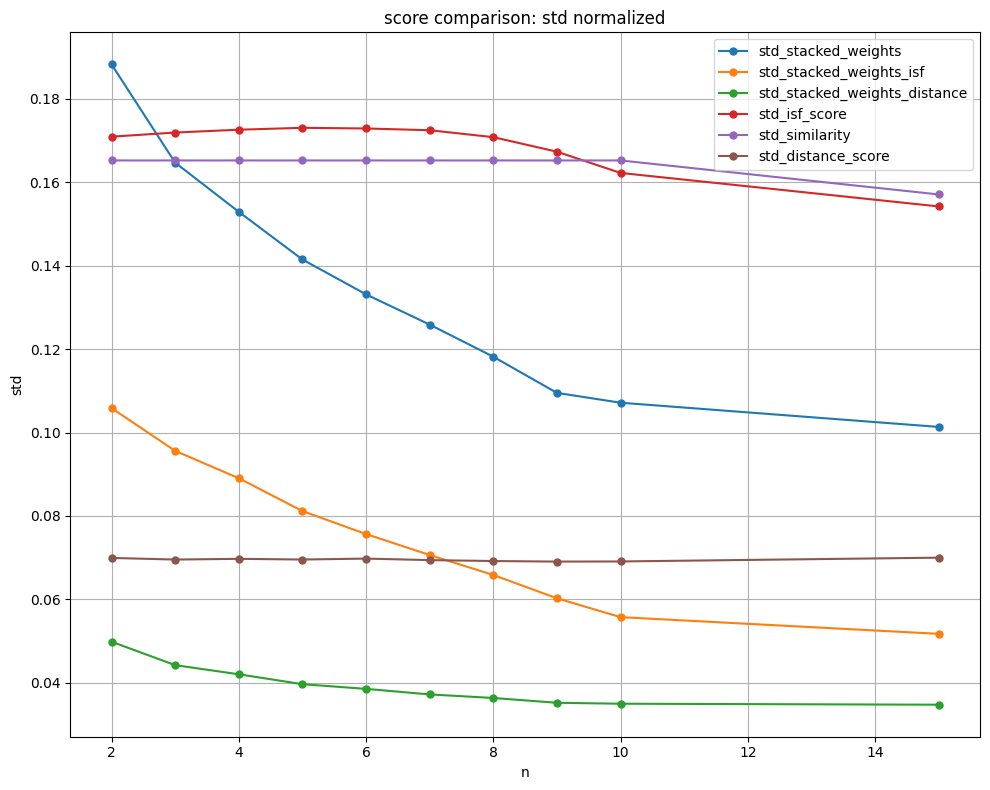

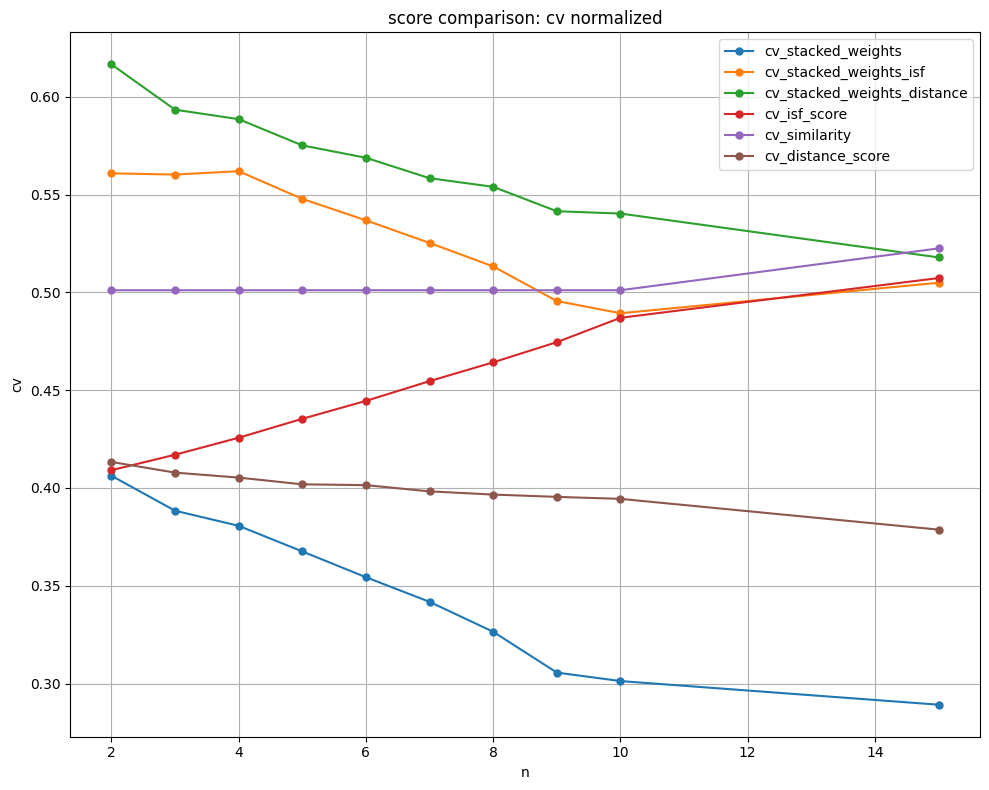

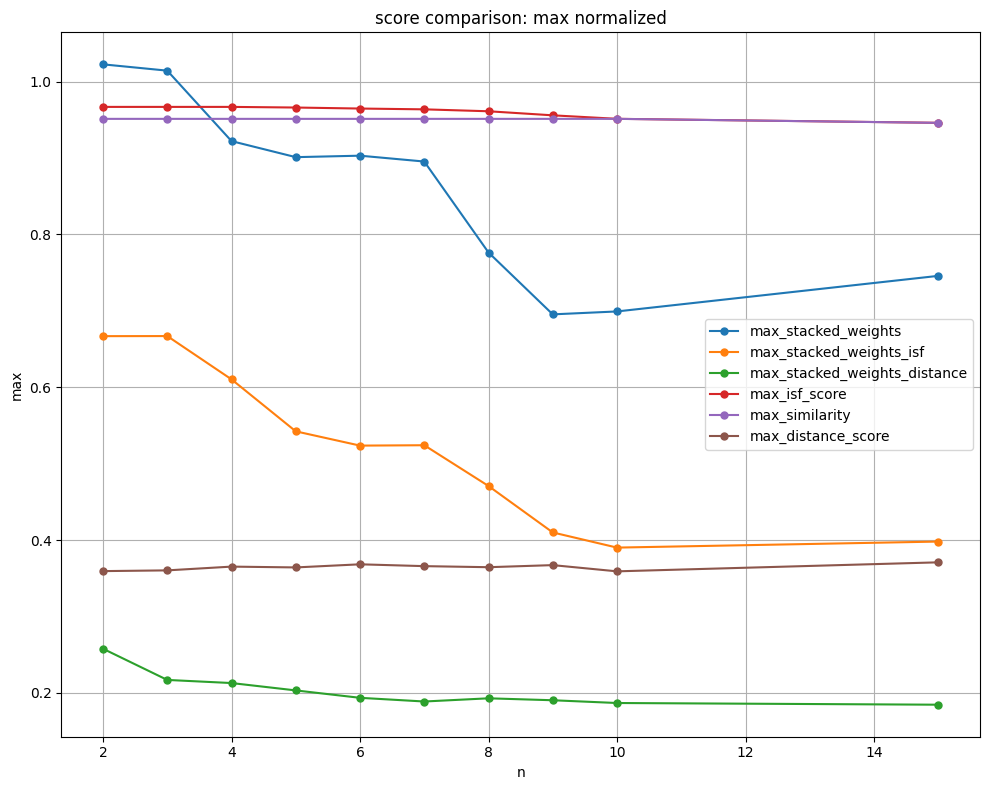

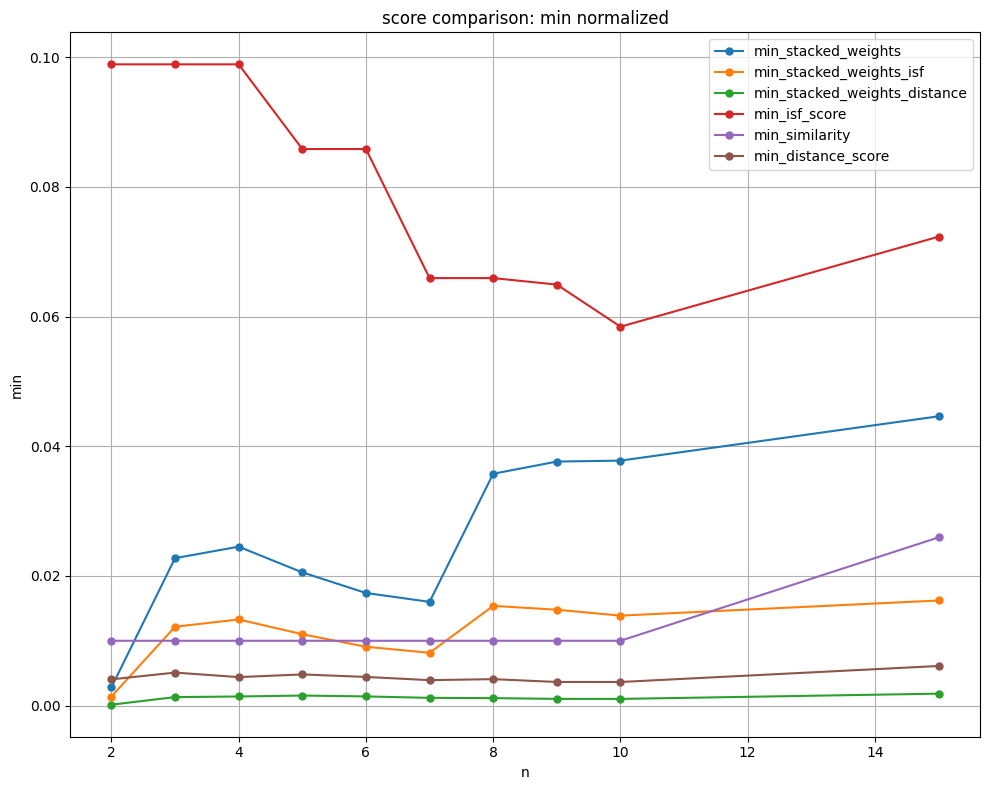

In [50]:
import matplotlib.pyplot as plt

for column in ["mean", "median", "std", "cv", "max", "min"]:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get the data for plotting
    x = weight_diff_benchmark_df['n']
    y_weights = weight_diff_benchmark_df[column]
    y_isf = weight_diff_benchmark_df[f"{column}_isf"]
    y_distance = weight_diff_benchmark_df[f"{column}_distance"]
    y_isf_score = weight_diff_benchmark_df[f"{column}_isf_score"]
    y_distance_score = weight_diff_benchmark_df[f"{column}_distance_score"]
    y_similarity = weight_diff_benchmark_df[f"{column}_similarity"]
    
    # Plot lines with different markers
    ax.plot(x, y_weights, label=f"{column}_stacked_weights", marker='o', markersize=5)
    ax.plot(x, y_isf, label=f"{column}_stacked_weights_isf", marker='o', markersize=5)
    ax.plot(x, y_distance, label=f"{column}_stacked_weights_distance", marker='o', markersize=5)
    ax.plot(x, y_isf_score, label=f"{column}_isf_score", marker='o', markersize=5)
    ax.plot(x, y_similarity, label=f"{column}_similarity", marker='o', markersize=5)
    ax.plot(x, y_distance_score, label=f"{column}_distance_score", marker='o', markersize=5)
    
    # Add value labels at each data point
    # for i in range(len(x)):
    #     ax.annotate(f"{y_weights.iloc[i]:.3f}", (x.iloc[i], y_weights.iloc[i]), 
    #                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    #     ax.annotate(f"{y_isf.iloc[i]:.3f}", (x.iloc[i], y_isf.iloc[i]), 
    #                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    #     ax.annotate(f"{y_distance.iloc[i]:.3f}", (x.iloc[i], y_distance.iloc[i]), 
    #                textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)
    #     ax.annotate(f"{y_isf_score.iloc[i]:.3f}", (x.iloc[i], y_isf_score.iloc[i]), 
    #                textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)
    #     ax.annotate(f"{y_distance_score.iloc[i]:.3f}", (x.iloc[i], y_distance_score.iloc[i]), 
    #                textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)
    #     ax.annotate(f"{y_similarity.iloc[i]:.3f}", (x.iloc[i], y_similarity.iloc[i]),
    #                  textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)
    
    ax.set_xlabel("n")
    ax.set_ylabel(column)
    ax.grid(True)
    ax.set_title(f"score comparison: {column} normalized")
    ax.legend()
    
    plt.tight_layout()
    plt.show()